In [3]:
# Importing Dependencies
import requests
import json
from private_info.config import api_key, fromdate, todate
from private_info.opendata_config import token311, password, username
import pandas as pd
from datetime import datetime
import sys
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
# sys.path.append('/path/to/your/dev/environment/lib/python3.10/site-packages')
from sodapy import Socrata
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default='svg'


### In the following script we'll try to analize the following
---
##### NYC311 can provide you access to non-emergency City services and information about City government programs. NYC311 can help with a broad range of services, including things like homeless person assistance, pothole repair, or help understanding a property tax bill. over 500 services

-  What are the top 10 complaints in NYC and how have they fluctuated in during the first quarter of this year? (2024) and what’s the average response time per complaint type during the first quarter of the year.
- What borough received the highest volume of 311 calls and what were the top calls in each borough?
- Which agencies are the busiest and are they working effectively? And how does that relates to the previous analysis. What is the trash situation in NYC ?


### Part 1: Cleaning the Data
### Extracting the First Trimester of 2024 from 311 Service Request Dataset from Open Data 

In [4]:
# Define Date Range
start_date = datetime(2024, 1, 1).isoformat()  # January 1, 2024
end_date = datetime(2024, 4, 1).isoformat()  # April 1, 2024


# Example of Authenticated Client (Needed for Non-Public Datasets):
client = Socrata(
    "data.cityofnewyork.us",
    token311,
    username= username,
    password= password,
    timeout=1000
)

# First 794354 results, returned as JSON from API / Converted to Python list of dictionaries by sodapy.
# Query dataset with Date Filter 
# In this Case we set a limit of limit=794354 because that's the Number of Rows we Need to Get the First Trimester, we Cannot Set it to Default because it only Retrives 1000 max.
results = client.get("erm2-nwe9", where=f"created_date between '{start_date}' and '{end_date}'", limit=794354)
print(len(results))
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)


794354


In [5]:
# Displaying the 311 Service Request DataFrame 
results_df

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,location,vehicle_type,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough
0,60746805,2024-04-01T00:00:00.000,2024-04-01T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,76 AINSLIE STREET,...,"{'latitude': '40.71256007953489', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60740007,2024-03-31T23:59:36.000,2024-04-01T05:20:38.000,DOT,Department of Transportation,Street Sign - Damaged,"No Parking, Standing, Stopping",Street,11205,920 KENT AVENUE,...,"{'latitude': '40.693075024696356', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60734332,2024-03-31T23:59:09.000,2024-04-01T09:12:45.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10454,313 EAST 140 STREET,...,"{'latitude': '40.81154285376075', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,60738841,2024-03-31T23:58:47.000,2024-04-02T22:34:59.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10128,1670 YORK AVENUE,...,"{'latitude': '40.777070197706855', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60739109,2024-03-31T23:58:39.000,2024-04-02T15:08:50.000,DOT,Department of Transportation,Street Condition,Defective Hardware,Street,10009,324 EAST 8 STREET,...,"{'latitude': '40.72501024136251', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794349,59887043,2024-01-01T00:00:20.000,2024-01-01T00:41:01.000,NYPD,New York City Police Department,Illegal Fireworks,N/A,Street/Sidewalk,11228,7223 FORT HAMILTON PARKWAY,...,"{'latitude': '40.62709413549678', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794350,59896272,2024-01-01T00:00:00.000,2024-01-02T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,145 GRAND STREET EXTENSION,...,"{'latitude': '40.710675306389646', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794351,59899838,2024-01-01T00:00:00.000,2024-01-02T09:42:25.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10022,1069 1 AVENUE,...,"{'latitude': '40.759191822016476', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794352,59894610,2024-01-01T00:00:00.000,2024-01-02T09:46:32.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10304,7 NAVY PIER COURT,...,"{'latitude': '40.628827651071944', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Getting a Brief Summary of the results_df DataFrame 
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794354 entries, 0 to 794353
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   unique_key                      794354 non-null  object
 1   created_date                    794354 non-null  object
 2   closed_date                     774412 non-null  object
 3   agency                          794354 non-null  object
 4   agency_name                     794354 non-null  object
 5   complaint_type                  794354 non-null  object
 6   descriptor                      788994 non-null  object
 7   location_type                   695950 non-null  object
 8   incident_zip                    785089 non-null  object
 9   incident_address                762451 non-null  object
 10  street_name                     762428 non-null  object
 11  cross_street_1                  502948 non-null  object
 12  cross_street_2                

In [7]:
# Getting the results_df Columns
results_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough'],
      dtype='object')

In [8]:
# Assigning location and location_subtype Values to the location and location_subtype Columns 
try:
    results_df[['location_', 'location_subtype']] = results_df['location_type'].str.split("/", n=1, expand=True)

except  ValueError:

    results_df['location_subtype'] = None 
results_df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough,location_,location_subtype
0,60746805,2024-04-01T00:00:00.000,2024-04-01T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,76 AINSLIE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Restaurant,Bar/Deli/Bakery
1,60740007,2024-03-31T23:59:36.000,2024-04-01T05:20:38.000,DOT,Department of Transportation,Street Sign - Damaged,"No Parking, Standing, Stopping",Street,11205,920 KENT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None
2,60734332,2024-03-31T23:59:09.000,2024-04-01T09:12:45.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10454,313 EAST 140 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
3,60738841,2024-03-31T23:58:47.000,2024-04-02T22:34:59.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10128,1670 YORK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
4,60739109,2024-03-31T23:58:39.000,2024-04-02T15:08:50.000,DOT,Department of Transportation,Street Condition,Defective Hardware,Street,10009,324 EAST 8 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None


In [9]:
# Getting the results_df columns to Check Changes 
results_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough', 'location_', 'location_subtype'],
      dtype='object')

In [10]:
# Double checking how the Columns look and dropping the location_type Column
results_df[['location_type', 'location_','location_subtype']]
results_df_ = results_df.drop(['location_type'], axis=1)
results_df_.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough', 'location_', 'location_subtype'],
      dtype='object')

### Complaints and Boroughs Dataframes
___

In [11]:
# Getting the Count of How Many Complaint Types in Total in the DataFrame
complaint_type = results_df['complaint_type'].unique()
complaint_type
# Displays the Count of Complaint Types
print(len(complaint_type))

183


In [12]:
# Getting the Count of How Many Boroughs in Total in the DataFrame
boroughs = results_df['borough'].unique()
boroughs
# Displays the Count of the Boroughs
print(len(boroughs))

6


In [13]:
# Getting the Count of How Many Agencies in Total in the DataFrame
agencies = results_df['agency'].unique()
agencies
# Displays the Count of the Agencies
print(len(agencies))

14


In [14]:
# Create Numpy Array for the complaints_type DataFrame
complaints_ids_numbers = np.arange(1, 184)
print(complaints_ids_numbers)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183]


In [15]:
# Create Numpy Array for the borough DataFrame
boroughs_ids_numbers = np.arange(1,7)
print(boroughs_ids_numbers)

[1 2 3 4 5 6]


In [16]:
# Create Numpy Array for the agency DataFrame
agencies_ids_numbers = np.arange(1,15)
print(agencies_ids_numbers)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [17]:
# Use a List Comprehension to add "cmpT" to Each complaints_ids_number as complaint_id 
complaints_ids = ["cmpT" + str(complaint_id) for complaint_id in complaints_ids_numbers]

# Use a List Comprehension to add "brgh" to Each boroughs_ids_number as complaint_id 
boroughs_ids = ['brgh' + str(borough_id) for borough_id in boroughs_ids_numbers]

# Use a List Comprehension to add "agc" to Each agencies_ids_numbers 
agencies_id = ['agc' + str(agencies_id) for agencies_id in agencies_ids_numbers]

In [18]:
# Create a borough DataFrame for the borough_ids 

boroughs_df = pd.DataFrame({
    "borough_id": boroughs_ids,
    "borough" : boroughs
})

# Create a category DataFrame for the complaints_ids 

complaints_df = pd.DataFrame({
    "complaint_id": complaints_ids,
    "complaint_type" : complaint_type
})

# Create a agency DataFrame for the agencies_id

agencies_df = pd.DataFrame({
    "agencies_id" : agencies_id,
    "agency" : agencies
})

# Displays the DataFrames

boroughs_df.head()
complaints_df.tail()
agencies_df.head()


,agencies_id,agency
0,agc1,DOHMH
1,agc2,DOT
2,agc3,HPD
3,agc4,NYPD
4,agc5,DCWP


In [19]:
# Export complaints_df as a CSV file
complaints_df.to_csv("Resources/complaints.csv", index=False)

In [20]:
# Export boroughs_df as a CSV File
boroughs_df.to_csv("Resources/boroughs.csv", index=False)

In [21]:
# Export boroughs_df as a CSV File
agencies_df.to_csv("Resources/agencies.csv", index=False)

### Updating 311 service dataframe datatype
---

In [22]:
# Create a copy of the results_df_ DataFrame 
copy_311service_request = results_df_.copy()
copy_311service_request.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough,location_,location_subtype
0,60746805,2024-04-01T00:00:00.000,2024-04-01T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,11211,76 AINSLIE STREET,AINSLIE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Restaurant,Bar/Deli/Bakery
1,60740007,2024-03-31T23:59:36.000,2024-04-01T05:20:38.000,DOT,Department of Transportation,Street Sign - Damaged,"No Parking, Standing, Stopping",11205,920 KENT AVENUE,KENT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None
2,60734332,2024-03-31T23:59:09.000,2024-04-01T09:12:45.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,10454,313 EAST 140 STREET,EAST 140 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
3,60738841,2024-03-31T23:58:47.000,2024-04-02T22:34:59.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,10128,1670 YORK AVENUE,YORK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
4,60739109,2024-03-31T23:58:39.000,2024-04-02T15:08:50.000,DOT,Department of Transportation,Street Condition,Defective Hardware,10009,324 EAST 8 STREET,EAST 8 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None


In [23]:
# Renaming the Descriptor Column
copy_311service_request = copy_311service_request.rename(columns={'descriptor': 'complaint_descriptor','location_': 'location_type'})

In [24]:
# Reordering the DataFrame with location and location_subtype after Descriptor 
# Ignoring the 'agency_name' column since the mMtadata says that column is currenlty showing Incorrect Values
nyc311_service_line = copy_311service_request[['unique_key', 'created_date', 'closed_date', 'agency',
       'complaint_type', 'complaint_descriptor','location_type','location_subtype', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough']]

In [25]:
# Converts the created_date, closed_date, due_date, and resolution_action_updated_date  Columns to Datetime Format

date_columns = ['created_date', 'closed_date', 'due_date', 'resolution_action_updated_date']
for col in date_columns:
    nyc311_service_line[col] = pd.to_datetime(nyc311_service_line[col])


/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_72763/2379949684.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_72763/2379949684.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_72763/2379949684.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [26]:
# Converts Latitude and Longitude Columns to Float Format
float_columns = ['latitude', 'longitude']
for float_column in float_columns:
    nyc311_service_line[float_column] = nyc311_service_line[float_column].astype(float)

# Converts y_coordinate_state_plane and x_coordinate_state_plane Columns to Integer Format
int_columns = ['y_coordinate_state_plane', 'x_coordinate_state_plane']
for int_column in int_columns:
    nyc311_service_line[int_column] = nyc311_service_line[int_column].notnull().astype(int)

# Converts incident_zip and unique_key to Integer Columns 
integers_columns = [ 'incident_zip'] # Here we have the Columns Without Nan Values 
for integer_columns in integers_columns:
    nyc311_service_line[integer_columns] = nyc311_service_line[integer_columns].notnull().astype(int)

/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_72763/2074501442.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_72763/2074501442.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_72763/2074501442.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [27]:
# Checking the Datatypes
nyc311_service_line.dtypes

unique_key                                object
created_date                      datetime64[ns]
closed_date                       datetime64[ns]
agency                                    object
complaint_type                            object
complaint_descriptor                      object
location_type                             object
location_subtype                          object
incident_zip                               int64
incident_address                          object
street_name                               object
cross_street_1                            object
cross_street_2                            object
intersection_street_1                     object
intersection_street_2                     object
address_type                              object
city                                      object
landmark                                  object
status                                    object
resolution_description                    object
resolution_action_up

In [28]:
# Merging the campaign_df with the category_df on the "category" Column and the subcategory_df on the "subcategory" Column

nyc311_merged_df = nyc311_service_line.merge(complaints_df, on='complaint_type', how='left').merge(boroughs_df, on='borough', how='left').merge(agencies_df, on='agency', how='left')
nyc311_merged_df.tail(10)


,unique_key,created_date,closed_date,agency,complaint_type,complaint_descriptor,location_type,location_subtype,incident_zip,incident_address,...,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough,complaint_id,borough_id,agencies_id
794344,59889054,2024-01-01 00:00:51,2024-01-01 00:29:32,NYPD,Noise - Street/Sidewalk,Loud Music/Party,Street,Sidewalk,1,85-04 95 AVENUE,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT8,brgh4,agc4
794345,59892651,2024-01-01 00:00:48,2024-01-01 00:48:34,NYPD,Noise - Street/Sidewalk,Loud Music/Party,Street,Sidewalk,1,41-52 72 STREET,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT8,brgh4,agc4
794346,59891528,2024-01-01 00:00:46,2024-01-01 01:07:17,NYPD,Illegal Fireworks,N/A,Residential Building,House,1,106-23 75 STREET,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT82,brgh4,agc4
794347,59888940,2024-01-01 00:00:43,2024-01-01 00:56:45,NYPD,Noise - Residential,Banging/Pounding,Residential Building,House,1,640 STANLEY AVENUE,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT5,brgh1,agc4
794348,59889016,2024-01-01 00:00:20,2024-01-01 00:59:31,NYPD,Noise - Residential,Loud Music/Party,Residential Building,House,1,233 LANDING ROAD,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT5,brgh2,agc4
794349,59887043,2024-01-01 00:00:20,2024-01-01 00:41:01,NYPD,Illegal Fireworks,N/A,Street,Sidewalk,1,7223 FORT HAMILTON PARKWAY,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT82,brgh1,agc4
794350,59896272,2024-01-01 00:00:00,2024-01-02 00:00:01,DOHMH,Food Poisoning,1 or 2,Restaurant,Bar/Deli/Bakery,1,145 GRAND STREET EXTENSION,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT1,brgh1,agc1
794351,59899838,2024-01-01 00:00:00,2024-01-02 09:42:25,DOHMH,Food Poisoning,1 or 2,Restaurant,Bar/Deli/Bakery,1,1069 1 AVENUE,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT1,brgh3,agc1
794352,59894610,2024-01-01 00:00:00,2024-01-02 09:46:32,DOHMH,Food Poisoning,1 or 2,Restaurant,Bar/Deli/Bakery,1,7 NAVY PIER COURT,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT1,brgh5,agc1
794353,59898042,2024-01-01 00:00:00,2024-01-02 09:24:45,DOHMH,Food Poisoning,1 or 2,Restaurant,Bar/Deli/Bakery,1,711 MORRIS PARK AVENUE,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,cmpT1,brgh2,agc1


In [29]:
# Exporting the  nyc311_service_line DataFrame as a CSV File. 
nyc311_merged_df.to_csv("Resources/nyc311_merged_df.csv", index=False)

#   Analysis

 ###  Part 2: Which are the top 10 most popular report ploblems 311 receives?
 -----
 

In [30]:
# Creating DataFrame to Get the Count of Top 10 Complaint Types
complaints_311 = nyc311_service_line.groupby("complaint_type")["unique_key"].count().reset_index().sort_values(by='unique_key', ascending=False)
top_10_complaints =  complaints_311.reset_index(drop=True).head(10)
# Here we Decided to Add Commas for Better Reading
top_10_complaints_withmap = top_10_complaints['unique_key'].map("{:,}".format)
top_10_complaints.rename(columns = {"unique_key": "unique_key_count"})
top_10_complaints.index = top_10_complaints.index + 1
top_10_complaints
# Displays the Top 10 Complaint Types
print(top_10_complaints_withmap)
top_10_complaints

0    123,083
1    106,450
2     68,498
3     43,067
4     28,192
5     19,016
6     17,625
7     17,406
8     17,331
9     15,722
Name: unique_key, dtype: object


,complaint_type,unique_key
1,Illegal Parking,123083
2,HEAT/HOT WATER,106450
3,Noise - Residential,68498
4,Blocked Driveway,43067
5,UNSANITARY CONDITION,28192
6,Street Condition,19016
7,Abandoned Vehicle,17625
8,PLUMBING,17406
9,PAINT/PLASTER,17331
10,Noise - Street/Sidewalk,15722


In [31]:
# !pip install -U kaleido

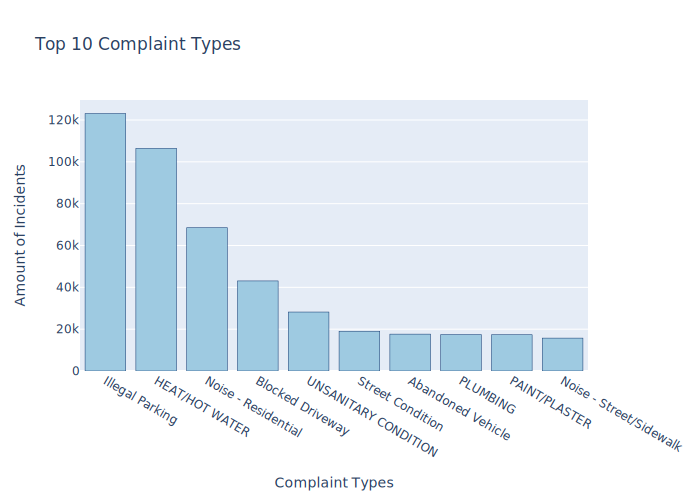

In [32]:
# Creating a Bar Chart to Present the Top 10 Complaint Types 
fig_top_10_complaints = px.bar(top_10_complaints, x='complaint_type', y='unique_key', 
                               title="Top 10 Complaint Types",
                               labels={'complaint_type':'Complaint Types',
                                       'unique_key': 'Amount of Incidents'})
fig_top_10_complaints.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)')
fig_top_10_complaints.show()

In [33]:
#H Create a Fuction to Look for the Top 10 Complaint Types during the Course of the First Three Months of the Year to not Repeat Ourselves

def analyze_complaint_types(start_date, end_date, data):
    # Filter Data Based on the Specified Start and End Date
    complaints_data = data.loc[(data['created_date'].dt.date >= start_date) & 
                               (data['created_date'].dt.date <= end_date), :]
    
    # Group by Complaint Type and Count the Unique Keys
    complaints_grouped = complaints_data.groupby("complaint_type")["unique_key"].count().reset_index().sort_values(by='unique_key', ascending=False)
    
    # Get the Top 10 Complaint Types
    top_10_complaints = complaints_grouped.reset_index(drop=True).head(10)
    
    # Format the Unique Key Count
    top_10_complaints['unique_key'] = top_10_complaints['unique_key'].map("{:,}".format)
    
    # Rename the Column
    top_10_complaints.rename(columns={"unique_key": "unique_key_count"}, inplace=True)
    
    # Adjust the Index to Start from 1
    top_10_complaints.index = top_10_complaints.index + 1
    
    return top_10_complaints

In [34]:
# Showing How the Complaint Types Change Over the Course of the Three Months 
# Converts the Date Strings to Datetime Objects
start_date_jan = pd.to_datetime('2024-01-01').date()
end_date_jan = pd.to_datetime('2024-01-31').date()

top_10_complaints_jan =  analyze_complaint_types(start_date_jan, end_date_jan, nyc311_service_line)
top_10_complaints_jan['Month'] = 'January'
top_10_complaints_jan


,complaint_type,unique_key_count,Month
1,HEAT/HOT WATER,"51,325",January
2,Illegal Parking,"41,124",January
3,Noise - Residential,"22,091",January
4,Blocked Driveway,"14,966",January
5,UNSANITARY CONDITION,"10,720",January
6,PLUMBING,"6,800",January
7,PAINT/PLASTER,"6,755",January
8,Abandoned Vehicle,"6,079",January
9,WATER LEAK,"5,863",January
10,Traffic Signal Condition,"5,225",January


In [35]:
# February Analysis
# Converts Date Strings to Datetime Objects
start_date_feb = pd.to_datetime('2024-02-01').date()
end_date_feb = pd.to_datetime('2024-02-29').date()


top_10_complaints_feb =  analyze_complaint_types(start_date_feb, end_date_feb, nyc311_service_line)
top_10_complaints_feb['Month'] = 'February'
top_10_complaints_feb


,complaint_type,unique_key_count,Month
1,Illegal Parking,"38,792",February
2,HEAT/HOT WATER,"30,316",February
3,Noise - Residential,"21,511",February
4,Blocked Driveway,"13,642",February
5,UNSANITARY CONDITION,"8,488",February
6,Street Condition,"5,870",February
7,Abandoned Vehicle,"5,387",February
8,PLUMBING,"5,260",February
9,PAINT/PLASTER,"4,970",February
10,Noise - Commercial,"4,552",February


In [36]:
# March Analysis
# Convert Date Strings to Datetime Objects
start_date_march = pd.to_datetime('2024-03-01').date()
end_date_march = pd.to_datetime('2024-03-31').date()

top_10_complaints_march =  analyze_complaint_types(start_date_march, end_date_march, nyc311_service_line)
top_10_complaints_march['Month'] = 'March'
top_10_complaints_march


,complaint_type,unique_key_count,Month
1,Illegal Parking,"43,167",March
2,Noise - Residential,"24,896",March
3,HEAT/HOT WATER,"24,809",March
4,Blocked Driveway,"14,459",March
5,UNSANITARY CONDITION,"8,984",March
6,Street Condition,"8,142",March
7,Noise - Street/Sidewalk,"7,609",March
8,Noise - Commercial,"6,376",March
9,Abandoned Vehicle,"6,159",March
10,PAINT/PLASTER,"5,606",March


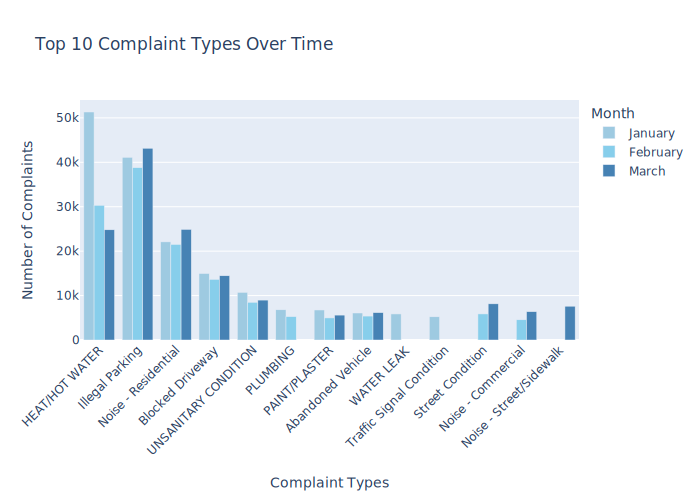

In [37]:
# Concatenating our Code in Order to Build a Bar Chart Presentating the Fluctuation of Complaint Types for the Three Months 

# Combining the Dataframes
combined_df = pd.concat([top_10_complaints_jan, top_10_complaints_feb, top_10_complaints_march], ignore_index=True)

# Ensuring 'unique_key_count' is Numeric
combined_df['unique_key_count'] = combined_df['unique_key_count'].str.replace(',', '').astype(int)
# ------------------------------------

# Defining Colors
colors = {
    'January': 'rgb(158,202,225)',
    'February': 'rgb(135,206,235)',  # Sky Blue
    'March': 'rgb(70,130,180)'       # Steel Blue
}

# Creating the Bar Chart
fig_top_10_complaints_overtime = px.bar(
    combined_df, 
    x='complaint_type', 
    y='unique_key_count', 
    color='Month', 
    color_discrete_map=colors,  # Apply color scheme
    barmode='group',            # Group bars by month
    title="Top 10 Complaint Types Over Time",
    labels={'complaint_type': 'Complaint Types', 'unique_key_count': 'Number of Complaints'}
)

# Customizing the Layout
fig_top_10_complaints_overtime.update_layout(
    xaxis_title='Complaint Types',
    yaxis_title='Number of Complaints',
    xaxis_tickangle=-45  # Rotate x-axis labels for better readability
)

# Showing the plot
fig_top_10_complaints_overtime.show()

In [92]:
# Displaying the same analysis but by borough

# borough_index311 = nyc311_service_line.set_index(['borough', 'complaint_type'])
complaints_by_borough = nyc311_service_line.groupby(["borough", "complaint_type"])["unique_key"].count().reset_index()
complaints_by_borough_sorted = complaints_by_borough.sort_values(by=['borough', 'unique_key'], ascending=[True, False])
top_10_complaints_by_borough = complaints_by_borough_sorted.groupby('borough').head(10).reset_index(drop=True)
top_10_complaints_by_borough['rank'] = top_10_complaints_by_borough.groupby('borough').cumcount( ascending= True)+1
top_10_complaints_by_borough.set_index(['borough', 'rank'], inplace=True)
top_10_complaints_by_borough['unique_key'] = top_10_complaints_by_borough['unique_key'].map("{:,}".format)
top_10_complaints_by_borough.head(10)


complaint_type unique_key
borough rank                                 
BRONX   1           HEAT/HOT WATER     39,312
        2          Illegal Parking     18,466
        3      Noise - Residential     17,944
        4     UNSANITARY CONDITION      9,521
        5         Blocked Driveway      6,367
        6            PAINT/PLASTER      6,306
        7                 PLUMBING      6,059
        8               WATER LEAK      4,517
        9              DOOR/WINDOW      4,488
        10       Derelict Vehicles      2,953

### Resolution Time Per Complaint (top 10)
---

In [39]:
# Creating a List of the Top 10 Complaints
top_ten_complaints_list = list(top_10_complaints['complaint_type'])

# Create a Resolution Response Time Column 
nyc311_time = nyc311_service_line.assign(resolution_response_time = lambda x: (x['resolution_action_updated_date'] - x['created_date']))
#substract the data in days and hours 
nyc311_time['resolution_response_days'] = nyc311_time['resolution_response_time'].dt.days
nyc311_time['resolution_response_hours'] = nyc311_time['resolution_response_time'].dt.total_seconds() / 3600
# Grouping by complaint_type and Filtering by the top_ten_complaints_list 
avg_resolution_timedf = nyc311_time.groupby(['complaint_type'])['resolution_response_time'].mean().reset_index().sort_values(by='resolution_response_time', ascending=False,na_position='first')
avg_resolution_timedf = avg_resolution_timedf.loc[(avg_resolution_timedf['complaint_type'].isin(top_ten_complaints_list)), :]
avg_resolution_timedf.reset_index(drop=True, inplace=True)
avg_resolution_timedf.index = avg_resolution_timedf.index +1 

# Check Datatype
avg_resolution_timedf.dtypes

# Converts timedelta to Hours, Minutes, and Seconds
avg_resolution_timedf['total_hours'] = avg_resolution_timedf['resolution_response_time'].dt.components['days'] * 24 + avg_resolution_timedf['resolution_response_time'].dt.components['hours']
avg_resolution_timedf['days'] = avg_resolution_timedf['resolution_response_time'].dt.components['days'] 
avg_resolution_timedf['hours'] = avg_resolution_timedf['resolution_response_time'].dt.components['hours']
avg_resolution_timedf['minutes'] = avg_resolution_timedf['resolution_response_time'].dt.components['minutes']
avg_resolution_timedf['seconds'] = avg_resolution_timedf['resolution_response_time'].dt.components['seconds']

avg_resolution_timedf

,complaint_type,resolution_response_time,total_hours,days,hours,minutes,seconds
1,UNSANITARY CONDITION,23 days 12:57:33.699524688,564,23,12,57,33
2,PLUMBING,21 days 04:58:05.829656440,508,21,4,58,5
3,PAINT/PLASTER,19 days 02:32:00.270151751,458,19,2,32,0
4,Street Condition,2 days 07:59:07.694593457,55,2,7,59,7
5,HEAT/HOT WATER,0 days 20:18:05.887552841,20,0,20,18,5
6,Abandoned Vehicle,0 days 03:30:40.776794326,3,0,3,30,40
7,Blocked Driveway,0 days 02:44:07.980773696,2,0,2,44,7
8,Illegal Parking,0 days 02:26:27.249928909,2,0,2,26,27
9,Noise - Residential,0 days 01:10:32.740926742,1,0,1,10,32
10,Noise - Street/Sidewalk,0 days 00:50:57.662638341,0,0,0,50,57


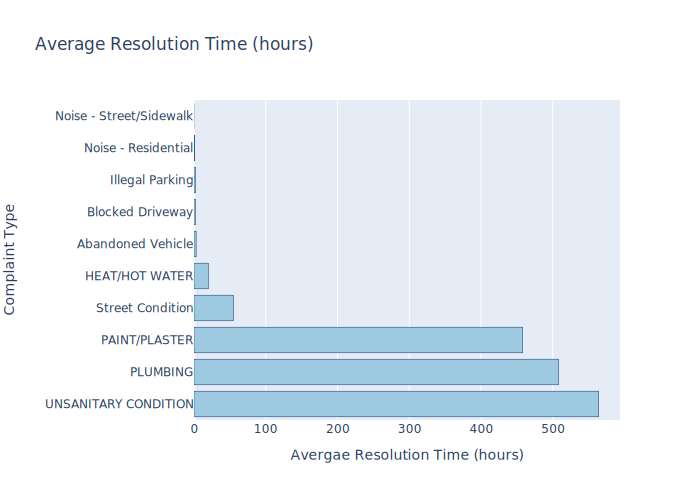

In [40]:
# Bar Chart of the Average Resolution Time they Take Per 10 Complaint Types

fig_top_10_avg_resolution_time = px.bar(avg_resolution_timedf, x="total_hours", y="complaint_type", orientation='h',
                                        title='Average Resolution Time (hours)',
                                        labels={'total_hours': 'Avergae Resolution Time (hours)',
                                                'complaint_type': 'Complaint Type'})
fig_top_10_avg_resolution_time.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)')
fig_top_10_avg_resolution_time.show()



### Volume Of Incidents Overtime
__________

In [41]:
# Volume of Calls 311 has Received Between Jan-Mar 2024
indicent_total_vol = len(nyc311_service_line['unique_key'].unique())
indicent_total_vol

794354

In [42]:
# Function to Determine the Total Volume of Calls per Month 

def volume_per_month(start_date, end_date, data):
    
    calls_total_vol_df = data.loc[(nyc311_service_line['created_date'].dt.date >= start_date) &
                                                (nyc311_service_line['created_date'].dt.date <= end_date), :]
    calls_total_vol_jan = len(calls_total_vol_df['unique_key'].unique())

    return  calls_total_vol_jan


In [43]:
# Getting the Amount of Calls In January
start_date_jan = pd.to_datetime('2024-01-01').date()
end_date_jan = pd.to_datetime('2024-01-31').date()

incident_total_vol_jan = volume_per_month(start_date_jan, end_date_jan, nyc311_service_line)
incident_total_vol_jan

287200

In [44]:
# Getting the Amount of Calls in February
start_date_feb = pd.to_datetime('2024-02-01').date()
end_date_feb = pd.to_datetime('2024-02-29').date()

incident_total_vol_feb = volume_per_month(start_date_feb, end_date_feb, nyc311_service_line)
incident_total_vol_feb

240454

In [45]:
# Getting the Amount of Calls in March
start_date_march = pd.to_datetime('2024-03-01').date()
end_date_march = pd.to_datetime('2024-03-31').date()

incident_total_vol_march = volume_per_month(start_date_march, end_date_march, nyc311_service_line)
incident_total_vol_march

266699

In [46]:
# Creates Snapshot Key Volume's Metrics in a DataFrame
incidents_vol_df = pd.DataFrame({"Total Indicents": [indicent_total_vol],
                                 "Total Indicents in January": incident_total_vol_jan,
                                 "Total Indicents in February":incident_total_vol_feb,
                                 "Total Indicents in March":incident_total_vol_march
                                 })

# Formatting
incidents_vol_df["Total Indicents"] = incidents_vol_df["Total Indicents"].map("{:,}".format)
incidents_vol_df["Total Indicents in January"] = incidents_vol_df["Total Indicents in January"].map("{:,}".format)
incidents_vol_df["Total Indicents in February"] = incidents_vol_df["Total Indicents in February"].map("{:,}".format)
incidents_vol_df["Total Indicents in March"] = incidents_vol_df["Total Indicents in March"].map("{:,}".format)

# Display the DataFrame
incidents_vol_df

,Total Indicents,Total Indicents in January,Total Indicents in February,Total Indicents in March
0,"794,354","287,200","240,454","266,699"


In [47]:
# Organizing nyc311_time Dataframe
nyc311_time['month'] = nyc311_time['created_date'].dt.month
nyc311_time['day'] = nyc311_time['created_date'].dt.day
nyc311_time['year'] = nyc311_time['created_date'].dt.year

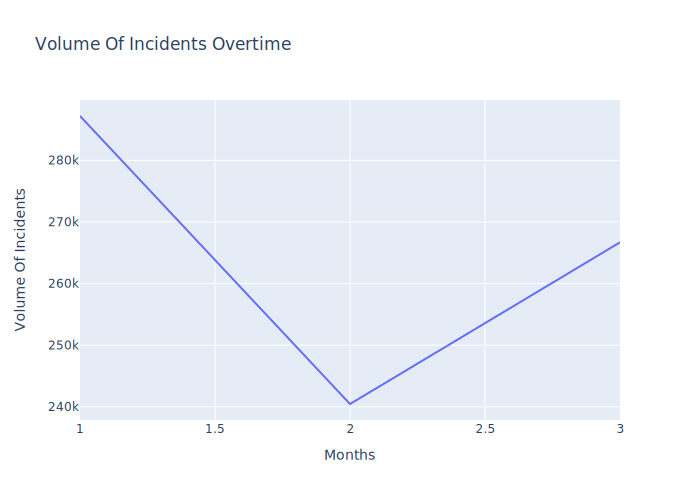

In [48]:
#Line chart for Incidents Over Time 
incidents_overtime = nyc311_time.loc[nyc311_time['month'] < 4, :]
incidents_by_months = incidents_overtime.groupby(['month'])['month'].count().reset_index(name='Count')
incidents_by_months

# Creates the Line Graph
fig_incidents_overtime = px.line(incidents_by_months, x="month", y="Count",
                                 title='Volume Of Incidents Overtime',
                                        labels={'Count': 'Volume Of Incidents',
                                                'month': 'Months'})
fig_incidents_overtime.update_traces(textposition="bottom right",marker_color='rgb(158,202,225)')
fig_incidents_overtime.show()

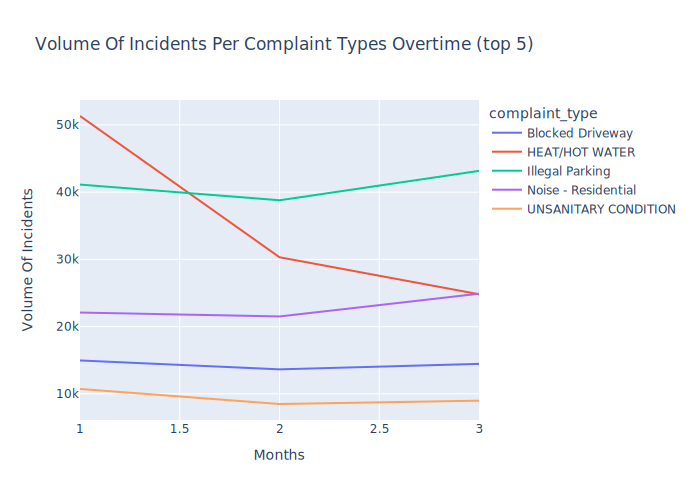

In [49]:
# Line Chart with the Top 5 Complaints Over Time 
# Query the Data to be Used in the Line Chart
top_ten_incidents_overtime = incidents_overtime.loc[(incidents_overtime['complaint_type'].isin(top_ten_complaints_list[0:5])), :]
complaints_by_type_month = top_ten_incidents_overtime.groupby(['month', 'complaint_type'])['month'].count().reset_index(name='Count')
complaints_by_type_month

# Creates the Line Graph
fig_complaints_by_type_month = px.line(complaints_by_type_month, x="month", y="Count", color='complaint_type',
                                       title='Volume Of Incidents Per Complaint Types Overtime (top 5) ',
                                        labels={'Count': 'Volume Of Incidents',
                                                'month': 'Months'})
fig_complaints_by_type_month.update_traces(textposition="bottom right")
fig_complaints_by_type_month.show()

In [50]:
# Creating a DataFrame with the Amount of Incidents Per Day of the Week to Verify if There is a Pattern

# Group by Day and Count Occurrences
day_counts = nyc311_time.groupby('day').size().reset_index(name='incidents_count')
day_counts
# Sort by Count in Descending Order and Get the Top 10 Days
top10_days = day_counts.sort_values(by='incidents_count', ascending=False).head(10)

# Reorder 'day' Based on 'Count' for Better Plotting
top10_days['day'] = pd.Categorical(top10_days['day'], categories=top10_days['day'].tolist(), ordered=True)
top10_days = top10_days.sort_values('day')

day_counts['incidents_count'] = day_counts['incidents_count'].map("{:,}".format)
day_counts.index = day_counts.index +1 
day_counts.head()

,day,incidents_count
1,1,"25,930"
2,2,"25,094"
3,3,"25,271"
4,4,"26,158"
5,5,"27,570"


In [51]:
# Creating a DataFrame Displaying the Busiest Week of the Month to Verify if There is a Trend

# Add a 'week_of_month' Column
nyc311_time['week_of_month'] = ((nyc311_time['created_date'].dt.day - 1) // 7) + 1

# Count Complaints per Week of each Month
weekly_counts = nyc311_time.groupby(['year', 'month', 'week_of_month']).size().reset_index(name='complaint_count')

# Find the Busiest Week for each Month
busiest_weeks = weekly_counts.loc[weekly_counts.groupby(['year', 'month'])['complaint_count'].idxmax()]
print("Busiest Week of Each Month:\n")
busiest_weeks


Busiest Week of Each Month:



,year,month,week_of_month,complaint_count
2,2024,1,3,69364
5,2024,2,1,60875
11,2024,3,2,62554
15,2024,4,1,1


### Part 3: What burough has the highest level of 311 calls?
---

In [52]:
# Check the Amount of Calls per Borough that is Reported 
boroughs_df = pd.DataFrame(nyc311_service_line['borough']).value_counts().reset_index()
boroughs_df

,borough,count
0,BROOKLYN,247148
1,QUEENS,190308
2,MANHATTAN,165901
3,BRONX,162956
4,STATEN ISLAND,27423
5,Unspecified,618


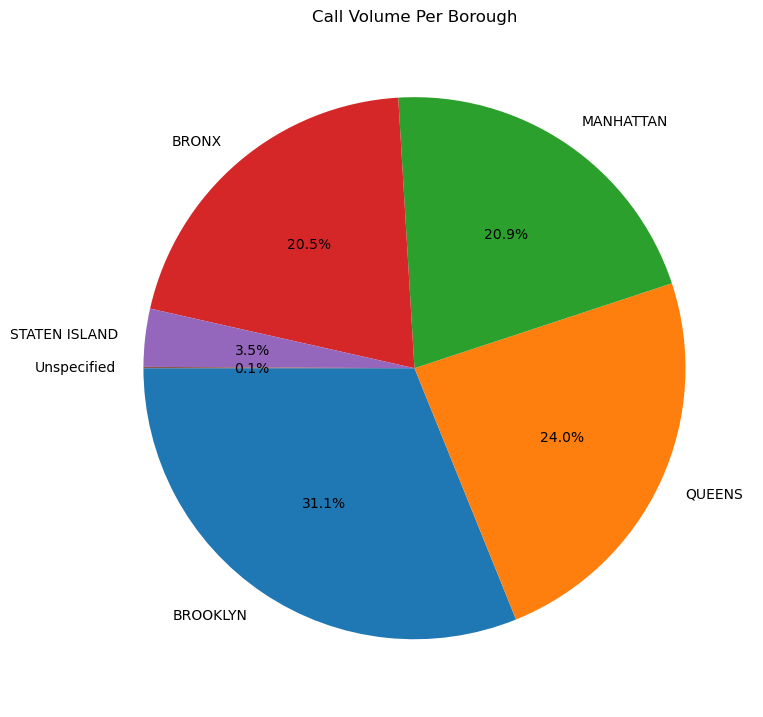

In [101]:
# Creating a Pie Chart to Display Findings 

borough_call_count= nyc311_service_line['borough'].value_counts()
plt.figure(figsize=(8.8,8.8)) # Setting the Figure Size of the Pie Graph
borough_call_count.plot.pie(autopct='%1.1f%%', startangle=180) # Setting Up and Coding the Pie Chart
plt.title('Call Volume Per Borough') # Title of Pie Chart
plt.ylabel('') # Gets Rid of Text on Y-axis
plt.show() # Displays Pie Chart


In [54]:
# Displays the Top 5 Counts of Each Complaint Type
complaint_df = nyc311_service_line['complaint_type'].value_counts()
complaint_df.head()

complaint_type
Illegal Parking         123083
HEAT/HOT WATER          106450
Noise - Residential      68498
Blocked Driveway         43067
UNSANITARY CONDITION     28192
Name: count, dtype: int64

In [55]:
# Displays the Bottom 5 Counts of Each Complaint Type
complaint_df = nyc311_service_line['complaint_type'].value_counts()
complaint_df.tail()

complaint_type
Building Marshals office           1
Construction Safety Enforcement    1
DSNY Internal                      1
Executive Inspections              1
Radioactive Material               1
Name: count, dtype: int64

In [56]:
# Creating a DataFrame of Complaint Types Per Borough to Make Analysis Easier
complaints_per_borough = nyc311_service_line[['complaint_type', 'borough']]
complaints_per_borough.head()


,complaint_type,borough
0,Food Poisoning,BROOKLYN
1,Street Sign - Damaged,BROOKLYN
2,HEAT/HOT WATER,BRONX
3,HEAT/HOT WATER,MANHATTAN
4,Street Condition,MANHATTAN


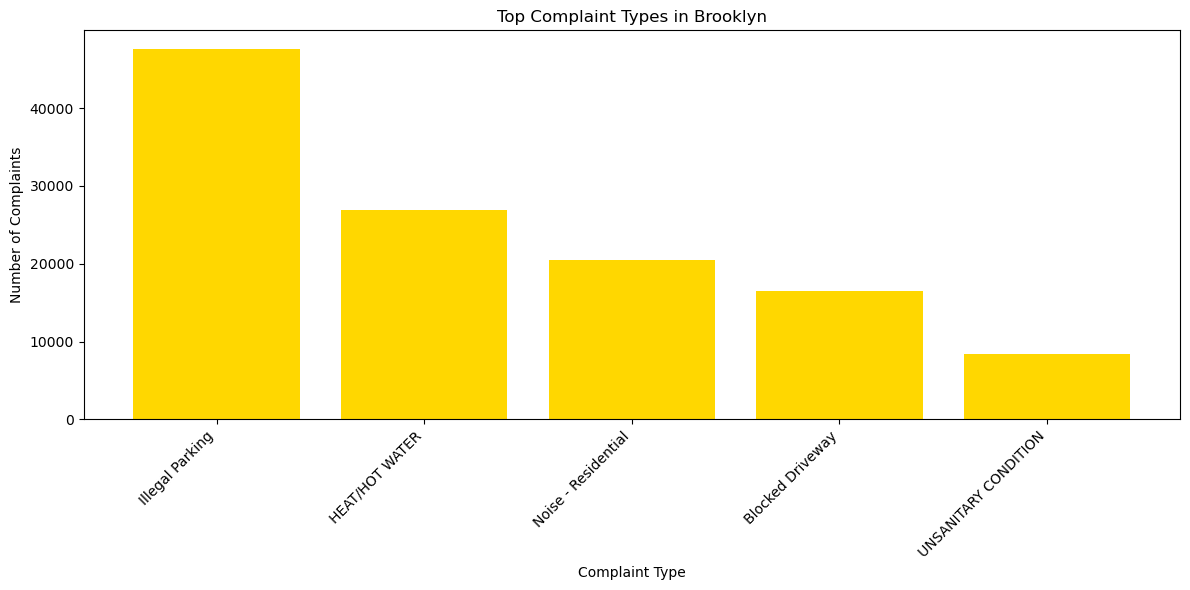

In [106]:
# Getting the Top 5 Complaints of Brooklyn
brooklyn_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'BROOKLYN']
brooklyn_complaints_counts = brooklyn_complaints.groupby('complaint_type').size()
brooklyn_complaints_df = brooklyn_complaints_counts.reset_index(name='count')
brooklyn_complaints_sorted = brooklyn_complaints_df.sort_values(by='count', ascending=False)
brooklyn_complaints_sorted.head()

# Creating the Bar Graph
plt.figure(figsize=(12, 6)) # Determines the Figure Size of the Bar Graph
plt.bar(brooklyn_complaints_sorted['complaint_type'][:5], brooklyn_complaints_sorted['count'][:5], color='gold') # Setting a Limit to Show the Top 5 Complaints
plt.xlabel('Complaint Type') # Label of the X-Axis
plt.ylabel('Number of Complaints') # Label of the Y-Axis
plt.title('Top Complaint Types in Brooklyn') # Title of the Bar Graph
plt.xticks(rotation=45, ha='right') # Rotates the Labels of the X-Axis
plt.tight_layout() # Adjusting Layout to Prevent Overlapping Elements
plt.show() # Displays the Bar Graph

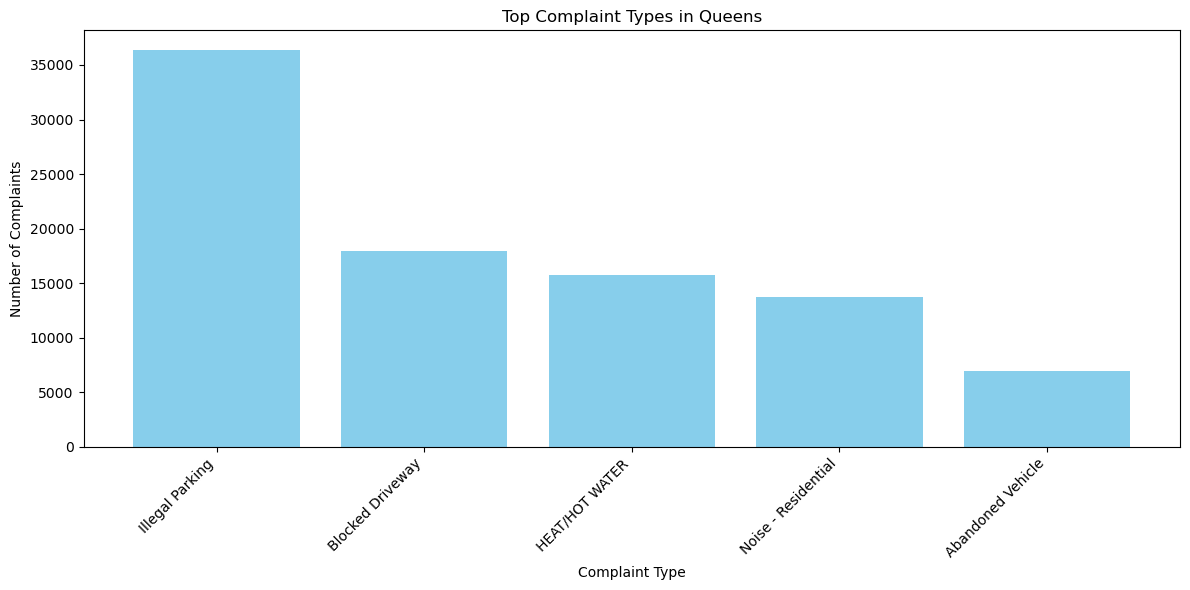

In [113]:
# Getting the Top 5 Complaints of Queens
queens_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'QUEENS']
queens_complaints_counts = queens_complaints.groupby('complaint_type').size()
queens_complaints_df = queens_complaints_counts.reset_index(name='count')
queens_complaints_sorted = queens_complaints_df.sort_values(by='count', ascending=False)
queens_complaints_sorted.head()

# Creating the Bar Graph
plt.figure(figsize=(12, 6)) # Determines the Figure Size of the Bar Graph
plt.bar(queens_complaints_sorted['complaint_type'][:5], queens_complaints_sorted['count'][:5], color='skyblue') # Setting a Limit to Show the Top 5 Complaints
plt.xlabel('Complaint Type') # Label of the X-Axis
plt.ylabel('Number of Complaints') # Label of the Y-Axis
plt.title('Top Complaint Types in Queens') # Title of the Bar Graph
plt.xticks(rotation=45, ha='right') # Rotates the Labels of the X-Axis
plt.tight_layout() # Adjusting Layout to Prevent Overlapping Elements
plt.show() # Displays the Bar Graph

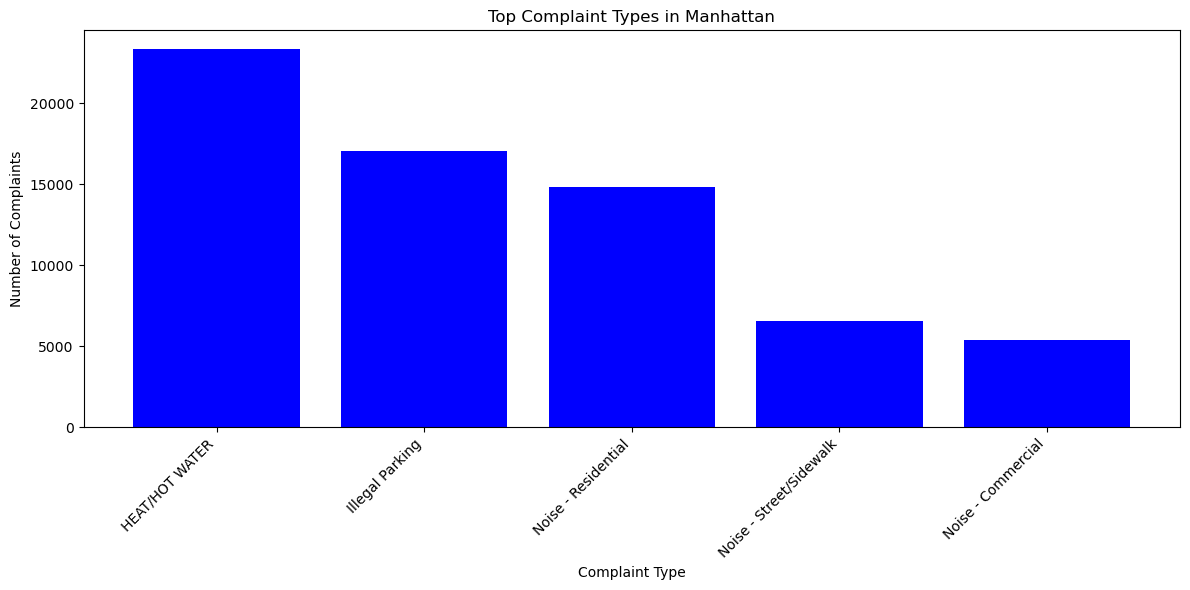

In [112]:
# Getting the Top 5 Complaints of Manhattan
manhattan_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'MANHATTAN']
manhattan_complaints_counts = manhattan_complaints.groupby('complaint_type').size()
manhattan_complaints_df = manhattan_complaints_counts.reset_index(name='count')
manhattan_complaints_sorted = manhattan_complaints_df.sort_values(by='count', ascending=False)
manhattan_complaints_sorted.head()

# Creating the Bar Graph
plt.figure(figsize=(12, 6)) # Determines the Figure Size of the Bar Graph
plt.bar(manhattan_complaints_sorted['complaint_type'][:5], manhattan_complaints_sorted['count'][:5], color='blue') # Setting a Limit to Show the Top 5 Complaints
plt.xlabel('Complaint Type') # Label of the X-Axis
plt.ylabel('Number of Complaints') # Label of the Y-Axis
plt.title('Top Complaint Types in Manhattan') # Title of the Bar Graph
plt.xticks(rotation=45, ha='right') # Rotates the Labels of the X-Axis
plt.tight_layout() # Adjusting Layout to Prevent Overlapping Elements
plt.show() # Displays the Bar Graph

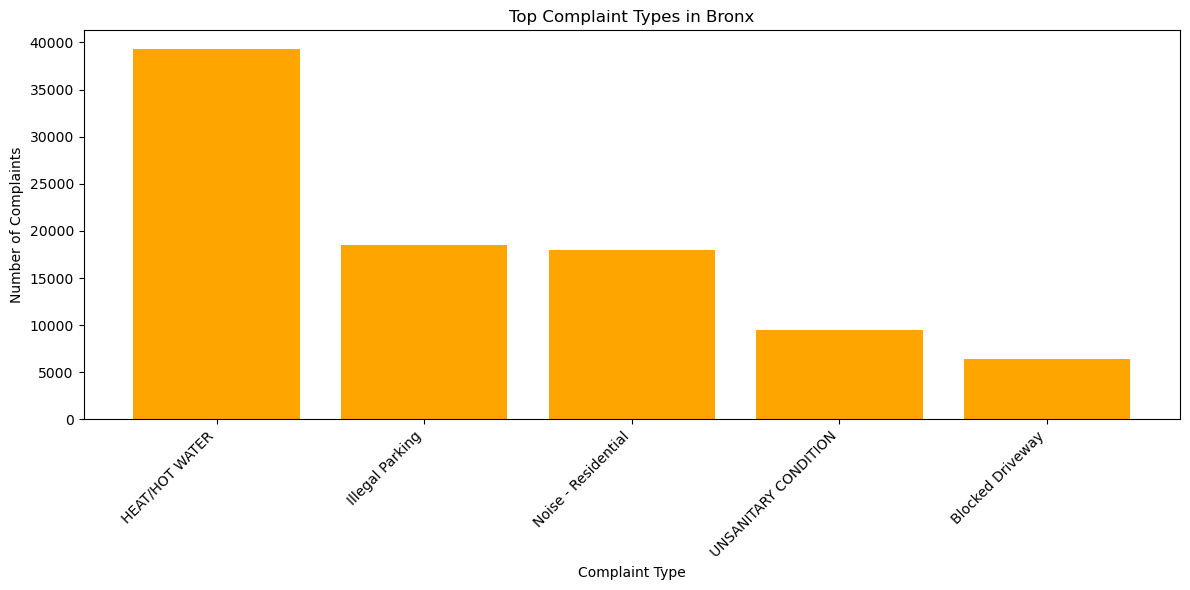

In [118]:
# Getting the Top 5 Complaints of the Bronx
bronx_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'BRONX']
bronx_complaints_counts = bronx_complaints.groupby('complaint_type').size()
bronx_complaints_df = bronx_complaints_counts.reset_index(name='count')
bronx_complaints_sorted = bronx_complaints_df.sort_values(by='count', ascending=False)
bronx_complaints_sorted.head()

# Creating the Bar Graph
plt.figure(figsize=(12, 6)) # Determines the Figure Size of the Bar Graph
plt.bar(bronx_complaints_sorted['complaint_type'][:5], bronx_complaints_sorted['count'][:5], color='orange') # Setting a Limit to Show the Top 5 Complaints
plt.xlabel('Complaint Type') # Label of the X-Axis
plt.ylabel('Number of Complaints') # Label of the Y-Axis
plt.title('Top Complaint Types in Bronx') # Title of the Bar Graph
plt.xticks(rotation=45, ha='right') # Rotates the Labels of the X-Axis
plt.tight_layout() # Adjusting Layout to Prevent Overlapping Elements
plt.show() # Displays the Bar Graph

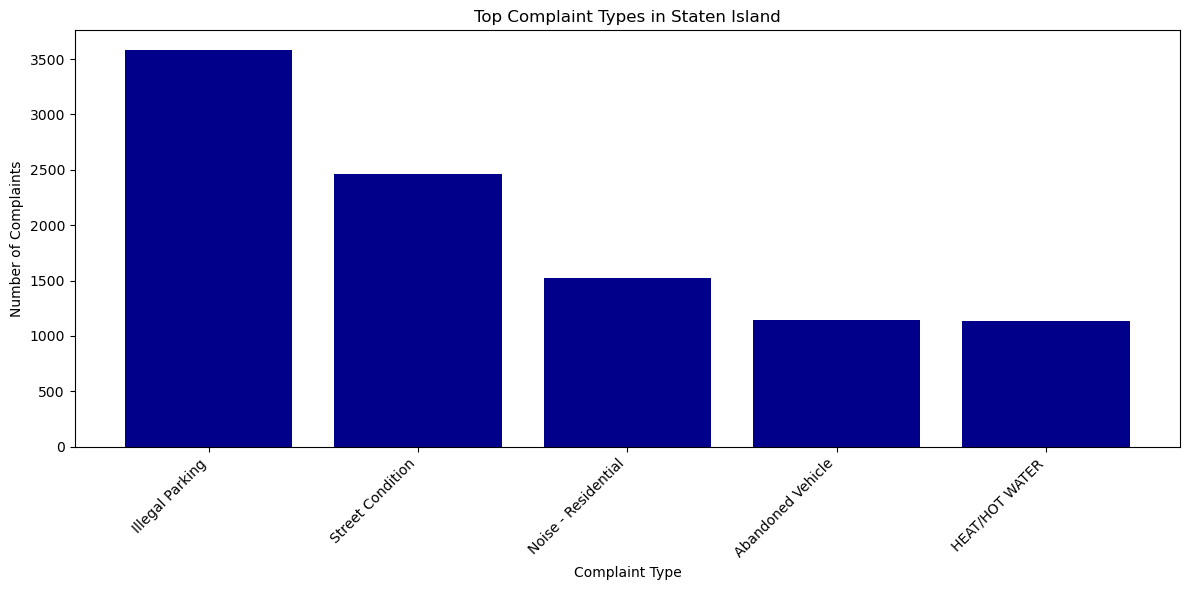

In [120]:
# Getting the Top 5 Complaints of Staten Island
staten_island_complaints = nyc311_service_line[nyc311_service_line['borough'] == 'STATEN ISLAND']
staten_island_complaints_counts = staten_island_complaints.groupby('complaint_type').size()
staten_island_complaints_df = staten_island_complaints_counts.reset_index(name='count')
staten_island_complaints_sorted = staten_island_complaints_df.sort_values(by='count', ascending=False)
staten_island_complaints_sorted.head()

# Creating the Bar Graph
plt.figure(figsize=(12, 6)) # Determines the Figure Size of the Bar Graph
plt.bar(staten_island_complaints_sorted['complaint_type'][:5], staten_island_complaints_sorted['count'][:5], color='darkblue') # Setting a Limit to Show the Top 5 Complaints
plt.xlabel('Complaint Type') # Label of the X-Axis
plt.ylabel('Number of Complaints') # Label of the Y-Axis
plt.title('Top Complaint Types in Staten Island') # Title of the Bar Graph
plt.xticks(rotation=45, ha='right') # Rotates the Labels of the X-Axis
plt.tight_layout() # Adjusting Layout to Prevent Overlapping Elements
plt.show() # Displays the Bar Graph

In [62]:
# Displays the Most Frequent Complaint Type Per Borough
complaints_count = complaints_per_borough.groupby(['borough', 'complaint_type']).size().reset_index(name='count')
# Finds the Index of the Highest Complaint Type of Each Borough
highest_complaint_idx = complaints_count.groupby('borough')['count'].idxmax()
highest_complaints_per_borough = complaints_count.loc[highest_complaint_idx].reset_index(drop=True)
highest_complaints_per_borough.index = highest_complaints_per_borough.index + 1
highest_complaints_per_borough

,borough,complaint_type,count
1,BRONX,HEAT/HOT WATER,39312
2,BROOKLYN,Illegal Parking,47599
3,MANHATTAN,HEAT/HOT WATER,23341
4,QUEENS,Illegal Parking,36358
5,STATEN ISLAND,Illegal Parking,3580
6,Unspecified,Ferry Inquiry,75


In [63]:
# Displays the Least Frequent Complaint Type Per Borough
complaints_count = complaints_per_borough.groupby(['borough', 'complaint_type']).size().reset_index(name='count')
# Finds the Index of the Lowest Complaint Type of Each Borough
lowest_complaint_idx = complaints_count.groupby('borough')['count'].idxmin()
lowest_complaints_per_borough = complaints_count.loc[lowest_complaint_idx].reset_index(drop=True)
lowest_complaints_per_borough.index = lowest_complaints_per_borough.index + 1
lowest_complaints_per_borough

,borough,complaint_type,count
1,BRONX,Animal Facility - No Permit,1
2,BROOKLYN,Animal Facility - No Permit,1
3,MANHATTAN,Building Condition,1
4,QUEENS,Building Marshals office,1
5,STATEN ISLAND,Borough Office,1
6,Unspecified,Bike Rack Condition,1


### Part 4: What Agency Has The Highest Call Rate?
----

In [64]:
# Finding the Unique Value of the Agencies that are Handling NYC 311 Complaints Between 01/01/24 and 04/01/24
unique_agency = nyc311_service_line["agency"].value_counts()
unique_agency

agency
NYPD     316884
HPD      228164
DSNY      65662
DOT       53678
DEP       38572
DOB       24812
DPR       19684
DOHMH     19168
TLC        8869
DHS        7190
EDC        7006
DCWP       4256
DOE         370
OTI          39
Name: count, dtype: int64

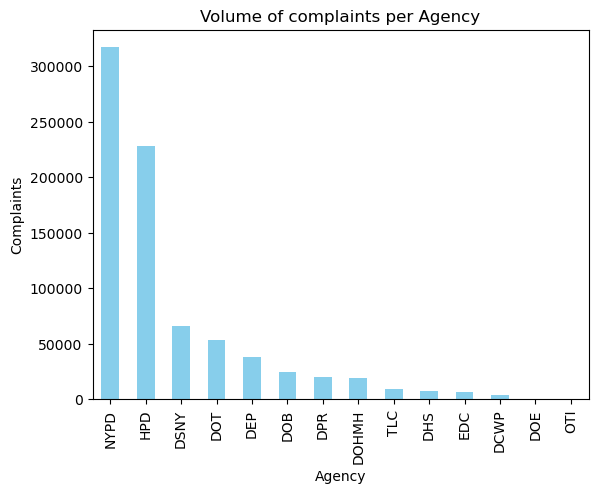

In [122]:
# Creating a DataFrame Referencing Only the Complaint Types and the Corresponding Agencies. Dataframe is Used to Create Following Dataframes for Visualizations
agency_per_complaint = nyc311_service_line[['complaint_type', 'agency']]
agency_per_complaint.head()


# Displays Bar chart Referencing the Volume of Complaint Type per Agency 
unique_agency.plot(x='agency', y='complaint_type', kind='bar', color='skyblue')
plt.xlabel('Agency')
plt.ylabel('Complaints')
plt.title('Volume of complaints per Agency')

plt.show()

In [130]:
# Displays what the Abbreviations Stand For
unique_agency_name = results_df_["agency_name"].value_counts()

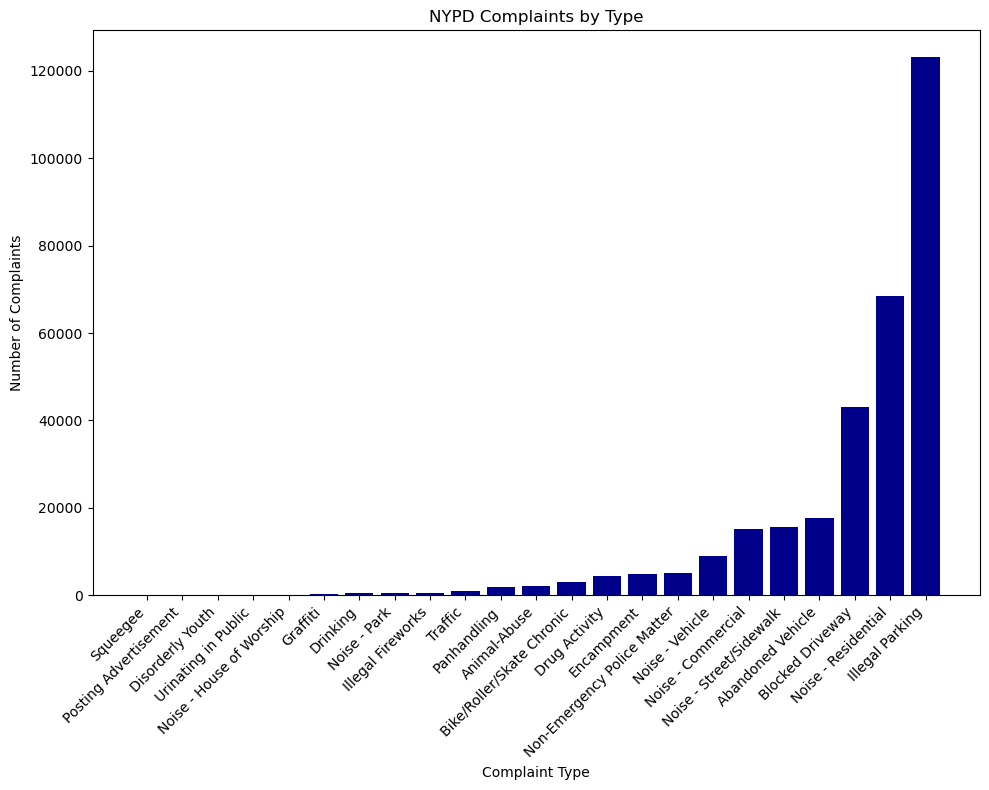

In [127]:

# Calculating the Count of Complaints for each Complaint Type for NYPD
nypd_complaints = agency_per_complaint.query('agency == "NYPD"').groupby('complaint_type').size().reset_index(name='NYPD')
nypd_complaints = nypd_complaints.sort_values(by=['NYPD', 'complaint_type'])
nypd_complaints = nypd_complaints.reset_index(drop=True)
nypd_complaints

# Creating a Histogram for NYPD using the Previous Data from nypd_complaints
plt.figure(figsize=(10,8))
plt.bar(nypd_complaints['complaint_type'], nypd_complaints['NYPD'], color='darkblue')
plt.title('NYPD Complaints by Type')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
nypd_complaints.sort_values('complaint_type')
plt.xticks(rotation=45, ha='right')  # Rotates Labels to 45 Degrees
plt.tight_layout()  # Adjusts Layout to Prevent Clipping of Tick Labels
plt.show()

In [67]:
# Creating a New Dataframe with the Columns: agency, complaint_type and created_date 
nypd_date = nyc311_service_line[(nyc311_service_line['agency'] == 'NYPD')]
nypd_date = nypd_date[['agency', 'complaint_type', 'created_date']]
nypd_date.head()

,agency,complaint_type,created_date
5,NYPD,Noise - Residential,2024-03-31 23:58:32
6,NYPD,Noise - Commercial,2024-03-31 23:58:22
7,NYPD,Illegal Parking,2024-03-31 23:58:21
8,NYPD,Noise - Street/Sidewalk,2024-03-31 23:58:12
9,NYPD,Illegal Parking,2024-03-31 23:57:53


In [68]:
# Analyzing the Top 3 Complaints for NYPD
# Creating a DataFrame Referencing the Total Number of Illegal Parking Complaints for each Day between 01/01/24 and 04/01/24
nypd_date['created_date'] = pd.to_datetime(nypd_date['created_date'])
nypd_date['created_date'] = nypd_date['created_date'].dt.date
illegal_parking_counts = nypd_date[nypd_date['complaint_type'] == 'Illegal Parking'].groupby('created_date').size().reset_index(name='Illegal parking')
illegal_parking_counts.head()

,created_date,Illegal parking
0,2024-01-01,1167
1,2024-01-02,1410
2,2024-01-03,1468
3,2024-01-04,1519
4,2024-01-05,1497


In [69]:
# Creating a DataFrame Referencing the Total Number of Residential Noise Complaints for each Day between 01/01/24 and 04/01/24
nypd_date['created_date'] = pd.to_datetime(nypd_date['created_date'])
nypd_date['created_date'] = nypd_date['created_date'].dt.date
noise_residential_counts = nypd_date[nypd_date['complaint_type'] == 'Noise - Residential'].groupby('created_date').size().reset_index(name='Residential noise')
noise_residential_counts.head()

,created_date,Residential noise
0,2024-01-01,1481
1,2024-01-02,605
2,2024-01-03,657
3,2024-01-04,562
4,2024-01-05,605


In [70]:
# Creating a DataFrame Referencing the Total Number of Blocked Driveway Complaints for each Day between 01/01/24 and 04/01/24
nypd_date['created_date'] = pd.to_datetime(nypd_date['created_date'])
nypd_date['created_date'] = nypd_date['created_date'].dt.date
blocked_driveway_counts = nypd_date[nypd_date['complaint_type'] == 'Blocked Driveway'].groupby('created_date').size().reset_index(name='Blocked driveway')
blocked_driveway_counts.head()

,created_date,Blocked driveway
0,2024-01-01,573
1,2024-01-02,500
2,2024-01-03,485
3,2024-01-04,509
4,2024-01-05,534


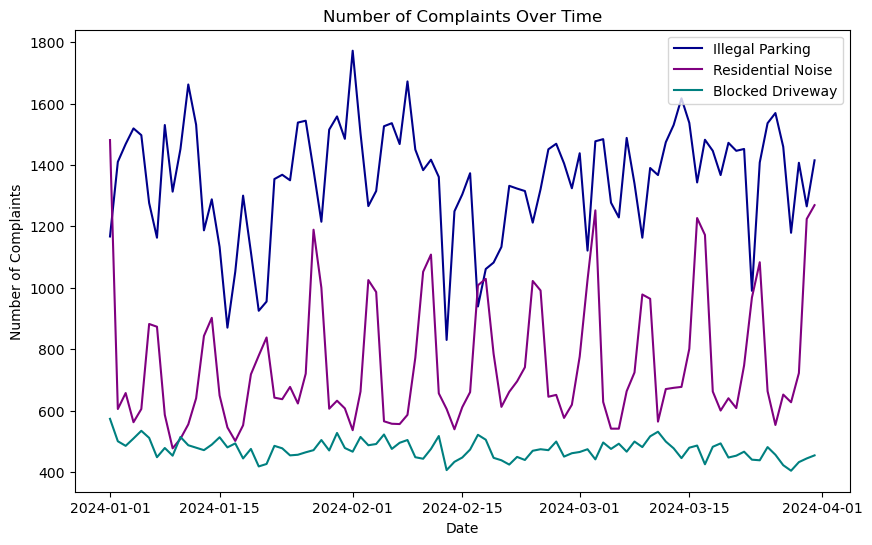

In [71]:
# Merging all Three Dataframes to Create a Line Graph to Study the Evolution of the Three NYPD Biggest Complaints over the First Trimester 
nypd_complaints_counts = illegal_parking_counts.merge(noise_residential_counts, on='created_date', how='outer').merge(blocked_driveway_counts, on='created_date', how='outer').fillna(0)
nypd_complaints_counts.head()

# Creating the line graph
# Converting the 'created_date' Column to Datetime Objects
nypd_complaints_counts['created_date'] = pd.to_datetime(nypd_complaints_counts['created_date'])

# Creating the line chart
plt.figure(figsize=(10, 6))
plt.plot(nypd_complaints_counts['created_date'], nypd_complaints_counts['Illegal parking'], label='Illegal Parking', color='darkblue')
plt.plot(nypd_complaints_counts['created_date'], nypd_complaints_counts['Residential noise'], label='Residential Noise', color='purple')
plt.plot(nypd_complaints_counts['created_date'], nypd_complaints_counts['Blocked driveway'], label='Blocked Driveway', color='teal')

# Adding Labels and Title
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints Over Time')

# Adding a Legend
plt.legend()

# Displaying the Plot
plt.show()

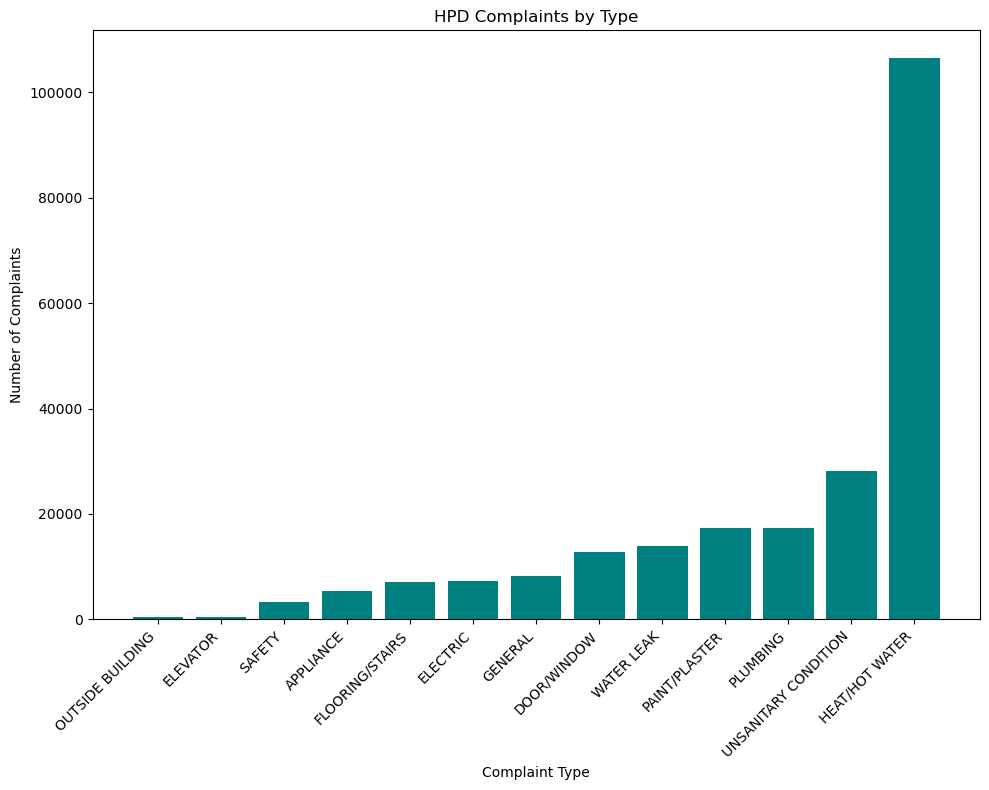

In [131]:
# Calculating the Count of Complaints for each Complaint Type for HPD
hpd_complaints = agency_per_complaint.query('agency == "HPD"').groupby('complaint_type').size().reset_index(name='HPD')
hpd_complaints = hpd_complaints.sort_values(by=['HPD', 'complaint_type'])
hpd_complaints = hpd_complaints.reset_index(drop=True)
hpd_complaints

# Creating a Histogram for HPD Using the Previous Data from hpd_complaints
plt.figure(figsize=(10,8))
plt.bar(hpd_complaints['complaint_type'], hpd_complaints['HPD'], color='teal')
plt.title('HPD Complaints by Type')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
hpd_complaints.sort_values('complaint_type')
plt.xticks(rotation=45, ha='right')  # Rotate Labels to 45 Degrees
plt.tight_layout()  # Adjust layout to Prevent Clipping of Tick Labels
plt.show()

In [73]:
# Creating a new DataFrame with the Columns: agency, complaint_type and created_date
hpd_date = nyc311_service_line[(nyc311_service_line['agency'] == 'HPD')]
hpd_date = hpd_date[['agency', 'complaint_type', 'created_date']]
hpd_date.head()


,agency,complaint_type,created_date
2,HPD,HEAT/HOT WATER,2024-03-31 23:59:09
3,HPD,HEAT/HOT WATER,2024-03-31 23:58:47
22,HPD,HEAT/HOT WATER,2024-03-31 23:55:44
42,HPD,HEAT/HOT WATER,2024-03-31 23:52:15
67,HPD,WATER LEAK,2024-03-31 23:46:32


In [74]:
# Analyzing the Top 3 Complaints for HPD
# Creating a DataFrame Referencing the Total Number of HEAT/HOT WATER Complaints for each Day between 01/01/24 and 04/01/24
hpd_date['created_date'] = pd.to_datetime(hpd_date['created_date'])
hpd_date['created_date'] = hpd_date['created_date'].dt.date
heat_hot_water_counts = hpd_date[hpd_date['complaint_type'] == 'HEAT/HOT WATER'].groupby('created_date').size().reset_index(name='HEAT/HOT WATER')
heat_hot_water_counts.head()


# Creating a DataFrame Referencing the Total Number of UNSANITARY CONDITION Complaints for each Day between 01/01/24 and 04/01/24
hpd_date['created_date'] = pd.to_datetime(hpd_date['created_date'])
hpd_date['created_date'] = hpd_date['created_date'].dt.date
unsanitary_condition_counts = hpd_date[hpd_date['complaint_type'] == 'UNSANITARY CONDITION'].groupby('created_date').size().reset_index(name='UNSANITARY CONDITION')
unsanitary_condition_counts.head()

# Creating a DataFrame Referencing the Total Number of PLUMBING Complaints for each Day between 01/01/24 and 04/01/24
hpd_date['created_date'] = pd.to_datetime(hpd_date['created_date'])
hpd_date['created_date'] = hpd_date['created_date'].dt.date
plumbing_counts = hpd_date[hpd_date['complaint_type'] == 'PLUMBING'].groupby('created_date').size().reset_index(name='PLUMBING')
plumbing_counts.head()

,created_date,PLUMBING
0,2024-01-01,104
1,2024-01-02,252
2,2024-01-03,239
3,2024-01-04,263
4,2024-01-05,215


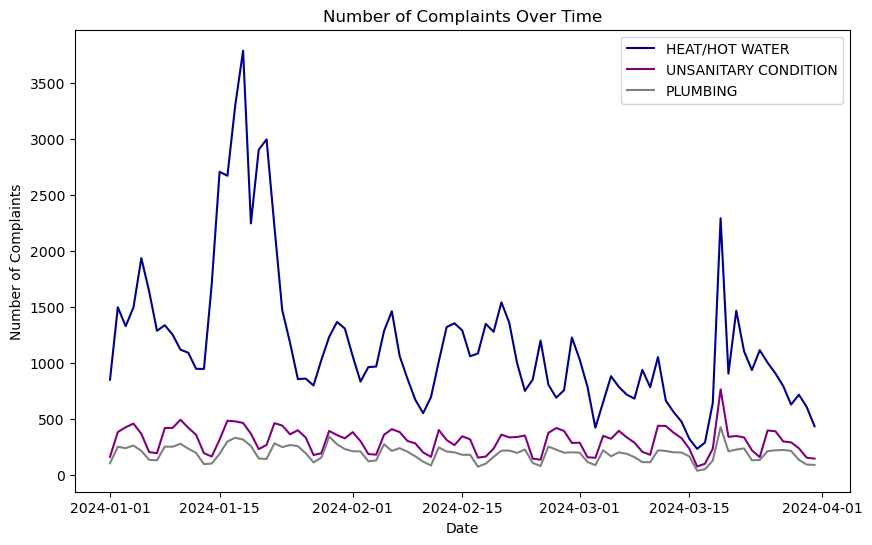

In [75]:
# Merging all Three DataFrames to Create a Line Graph and Study the Evolution of the Three HPD Biggest Complaints over 3 Months 
hpd_complaints_counts = heat_hot_water_counts.merge(unsanitary_condition_counts, on='created_date', how='outer').merge(plumbing_counts, on='created_date', how='outer').fillna(0)
hpd_complaints_counts.head()


# Creating the Line Graph
# Convert the 'created_date' Column to Datetime Objects
hpd_complaints_counts['created_date'] = pd.to_datetime(hpd_complaints_counts['created_date'])

# Creating a Line Chart
plt.figure(figsize=(10, 6))
plt.plot(hpd_complaints_counts['created_date'], hpd_complaints_counts['HEAT/HOT WATER'], label='HEAT/HOT WATER', color='darkblue')
plt.plot(hpd_complaints_counts['created_date'], hpd_complaints_counts['UNSANITARY CONDITION'], label='UNSANITARY CONDITION', color='purple')
plt.plot(hpd_complaints_counts['created_date'], hpd_complaints_counts['PLUMBING'], label='PLUMBING', color='grey')

# Adding Labels and Title
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints Over Time')

# Adding a Legend
plt.legend()

# Displaying the Plot
plt.show()

                            complaint_type   DSNY
0                            DSNY Internal      1
1                         Oil or Gas Spill      2
2                           Incorrect Data      5
3           Institution Disposal Complaint      9
4                       Retailer Complaint      9
5               Recycling Basket Complaint     10
6                           Adopt-A-Basket     14
7                      Seasonal Collection    140
8                  Litter Basket Complaint    207
9                            Lot Condition    264
10                      Dumpster Complaint    378
11                          Abandoned Bike    533
12  Sanitation Worker or Vehicle Complaint    580
13                   Litter Basket Request    777
14                         Illegal Posting    908
15           Commercial Disposal Complaint   1018
16               Street Sweeping Complaint   1644
17                             Dead Animal   2014
18          Residential Disposal Complaint   2912


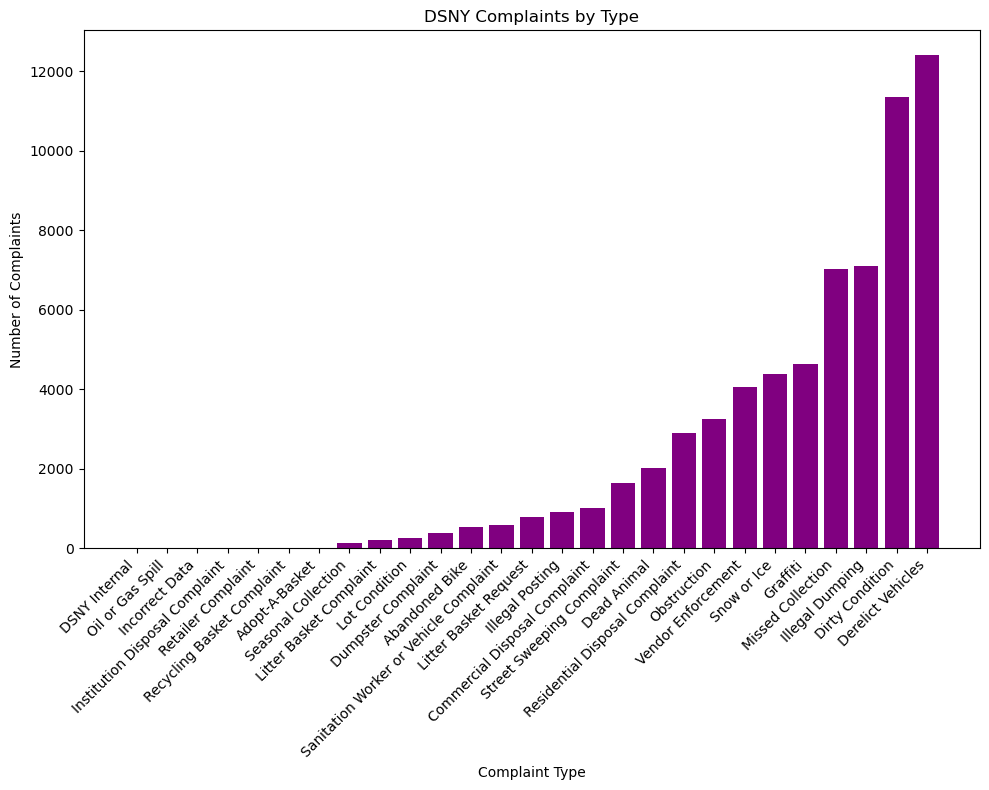

In [135]:
# Analyzing the Top 3 Complaints for DSNY
dsny_complaints = agency_per_complaint.query('agency == "DSNY"').groupby('complaint_type').size().reset_index(name='DSNY')
dsny_complaints = dsny_complaints.sort_values(by=['DSNY', 'complaint_type'])
dsny_complaints = dsny_complaints.reset_index(drop=True)
print(dsny_complaints)

	
dirty_conditions = results_df[results_df['complaint_type'] == 'Dirty Condition']
dirty_conditions

# Creating a Histogram for DSNY Using the Previous Data from dsny_complaints
plt.figure(figsize=(10,8))
plt.bar(dsny_complaints['complaint_type'], dsny_complaints['DSNY'], color='purple')
plt.title('DSNY Complaints by Type')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
dsny_complaints.sort_values('complaint_type')
plt.xticks(rotation=45, ha='right')  # Rotate Labels to 45 Degrees
plt.tight_layout()  # Adjust Layout to Prevent Clipping of Tick Labels
plt.show()
plt.show()

In [137]:
# Using the Code from Queastion 1, Calculating the Response Time for the DSNY Biggest Complaint which is Derelict Vehicles
complaints_311 = nyc311_service_line.groupby("complaint_type")["unique_key"].count().reset_index().sort_values(by='unique_key', ascending=False)
top_30_complaints =  complaints_311.reset_index(drop=True).head(30)
top_30_complaints_withmap = top_30_complaints['unique_key'].map("{:,}".format)
top_30_complaints.rename(columns = {"unique_key": "unique_key_count"})
top_30_complaints.index = top_30_complaints.index + 1
top_30_complaints

print(top_30_complaints_withmap)
top_30_complaints.head()


# Creating a Fuction to Look for the Top 10 Complaint Types During the Course of the First Three Months of the Year to not Repeat Ourselves:

def analyze_complaint_types(start_date, end_date, data):
    # Filter Data Based on the Specified Start and End Dates
    complaints_data = data.loc[(data['created_date'].dt.date >= start_date) & 
                               (data['created_date'].dt.date <= end_date), :]
    
    # Group by Complaint Type and Count of the Unique Keys
    complaints_grouped = complaints_data.groupby("complaint_type")["unique_key"].count().reset_index().sort_values(by='unique_key', ascending=False)
    
    # Get the Top 10 Complaint Types
    top_30_complaints = complaints_grouped.reset_index(drop=True).head(30)
    
    # Format the Unique Key Count
    top_30_complaints['unique_key'] = top_30_complaints['unique_key'].map("{:,}".format)
    
    # Rename the Column
    top_30_complaints.rename(columns={"unique_key": "unique_key_count"}, inplace=True)
    
    # Adjust the Index to Start from 1
    top_30_complaints.index = top_10_complaints.index + 1
    
    return top_30_complaints


0     123,083
1     106,450
2      68,498
3      43,067
4      28,192
5      19,016
6      17,625
7      17,406
8      17,331
9      15,722
10     15,165
11     13,933
12     13,345
13     12,917
14     12,755
15     12,412
16     11,357
17     10,600
18      9,182
19      9,093
20      8,629
21      8,257
22      8,099
23      7,277
24      7,222
25      7,137
26      7,105
27      7,020
28      7,006
29      6,742
Name: unique_key, dtype: object


In [139]:
# Create a List of the top 20 Complaints
top_thirty_complaints_list = list(top_30_complaints['complaint_type'])

# Create a Resolution Response Time Column 
nyc311_time = nyc311_service_line.assign(resolution_response_time = lambda x: (x['resolution_action_updated_date'] - x['created_date']))
# Substract the Data in Days and Hours 
nyc311_time['resolution_response_days'] = nyc311_time['resolution_response_time'].apply(lambda x: x.days)
nyc311_time['resolution_response_seconds'] = nyc311_time['resolution_response_time'].apply(lambda x: x.seconds)
# Group by Complaint Type and the Filter by the top_ten_complaints_list 
avg_resolution_timedf = nyc311_time.groupby(['complaint_type'])['resolution_response_time'].mean().reset_index().sort_values(by='resolution_response_time', ascending=False,na_position='first')
avg_resolution_timedf = avg_resolution_timedf.loc[(avg_resolution_timedf['complaint_type'].isin(top_thirty_complaints_list)), :]
avg_resolution_timedf.reset_index(drop=True, inplace=True)
avg_resolution_timedf.index = avg_resolution_timedf.index +1 

# Check Datatype
avg_resolution_timedf.dtypes

# Convert Timedelta to Hours, Minutes, and Seconds
avg_resolution_timedf['total_seconds'] = avg_resolution_timedf['resolution_response_time'].apply(lambda x: x.total_seconds())
avg_resolution_timedf['days'] = avg_resolution_timedf['total_seconds'] // (24 * 3600)
avg_resolution_timedf['hours'] = (avg_resolution_timedf['total_seconds'] // 3600) % 24
avg_resolution_timedf['minutes'] = (avg_resolution_timedf['total_seconds'] // 60) % 60
avg_resolution_timedf['seconds'] = avg_resolution_timedf['total_seconds'] % 60
avg_resolution_timedf['total_hours'] = avg_resolution_timedf['days'] * 24 + avg_resolution_timedf['hours']

avg_resolution_timedf.head()

,complaint_type,resolution_response_time,total_seconds,days,hours,minutes,seconds,total_hours
1,WATER LEAK,28 days 08:53:09.203043135,2.451189e+06,28.0,8.0,53.0,9.203043,680.0
2,GENERAL,27 days 21:11:54.996366719,2.409115e+06,27.0,21.0,11.0,54.996366,669.0
3,DOOR/WINDOW,26 days 07:38:43.854880439,2.273924e+06,26.0,7.0,38.0,43.854880,631.0
4,Noise - Helicopter,25 days 10:45:17.938234451,2.198718e+06,25.0,10.0,45.0,17.938234,610.0
5,UNSANITARY CONDITION,23 days 12:57:33.699524688,2.033854e+06,23.0,12.0,57.0,33.699524,564.0


In [140]:
# Creating a new DataFrame for the Average Response Time for Only the Derelict Vehicles Complaints
derelict_vehicles_avg_resolution_timedf = avg_resolution_timedf[(avg_resolution_timedf['complaint_type']=='Derelict Vehicles')]
derelict_vehicles_avg_resolution_timedf

,complaint_type,resolution_response_time,total_seconds,days,hours,minutes,seconds,total_hours
18,Derelict Vehicles,1 days 07:11:37.115694489,112297.115694,1.0,7.0,11.0,37.115694,31.0


In [77]:
# Creating a New DataFrame with the Columns: agency, complaint_type and created_date
dsny_date = nyc311_service_line[(nyc311_service_line['agency'] == 'DSNY')]
dsny_date = dsny_date[['agency', 'complaint_type', 'created_date']]
dsny_date

# Analyzing the top 4 Complaints for HPD
# Analyzing the 4th Biggest complaint because Missed Collection is Linked to the Current NYC Trash Problem
# Creating a DataFrame Referencing the Total Number of Derelict Vehicles Complaints for each Day between 01/01/24 and 04/01/24
dsny_date['created_date'] = pd.to_datetime(dsny_date['created_date'])
dsny_date['created_date'] = dsny_date['created_date'].dt.date
derelict_vehicles_counts = dsny_date[dsny_date['complaint_type'] == 'Derelict Vehicles'].groupby('created_date').size().reset_index(name='Derelict Vehicles')
derelict_vehicles_counts.head()



,created_date,Derelict Vehicles
0,2024-01-01,82
1,2024-01-02,132
2,2024-01-03,150
3,2024-01-04,178
4,2024-01-05,164


In [78]:
# Creating a DataFrame Referencing the Total Number of Dirty Condition Complaints for each Day between 01/01/24 and 04/01/24
dsny_date['created_date'] = pd.to_datetime(dsny_date['created_date'])
dsny_date['created_date'] = dsny_date['created_date'].dt.date
dirty_condition_counts = dsny_date[dsny_date['complaint_type'] == 'Dirty Condition'].groupby('created_date').size().reset_index(name='Dirty Condition')
dirty_condition_counts

# Creating a DataFrame Referencing the Total Number of Illegal Dumping Complaints for each Day between 01/01/24 and 04/01/24
dsny_date['created_date'] = pd.to_datetime(dsny_date['created_date'])
dsny_date['created_date'] = dsny_date['created_date'].dt.date
illegal_dumping_counts = dsny_date[dsny_date['complaint_type'] == 'Illegal Dumping'].groupby('created_date').size().reset_index(name='Illegal Dumping')
illegal_dumping_counts

# Creating a DataFrame Referencing the Total Number of Missed Collection Complaints for each Day between 01/01/24 and 04/01/24
dsny_date['created_date'] = pd.to_datetime(dsny_date['created_date'])
dsny_date['created_date'] = dsny_date['created_date'].dt.date
missed_collection_counts = dsny_date[dsny_date['complaint_type'] == 'Missed Collection'].groupby('created_date').size().reset_index(name='Missed Collection')
missed_collection_counts.head()

,created_date,Missed Collection
0,2024-01-01,17
1,2024-01-02,15
2,2024-01-03,3
3,2024-01-04,7
4,2024-01-05,159


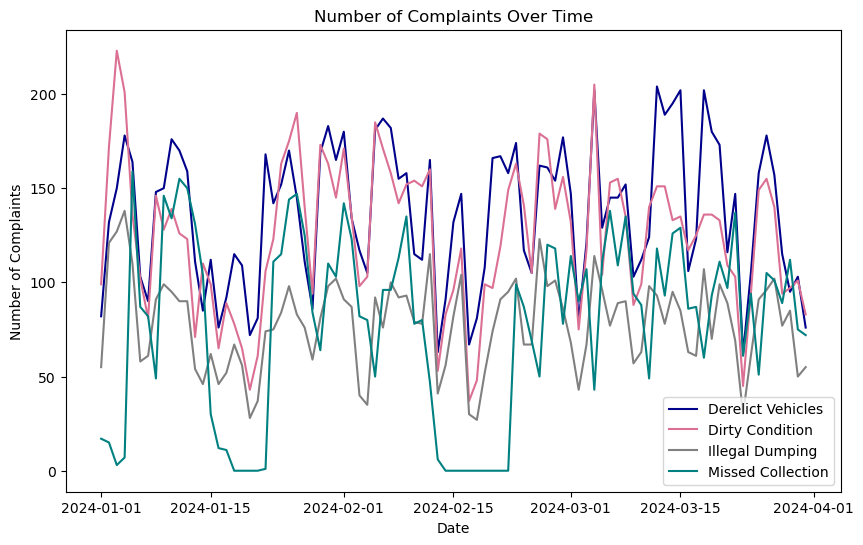

In [79]:
# Merging all Four DataFrames to Create a Line Graph and Study the Evolution of the Three Biggest Complaints of HPD Over 3 Months
dsny_complaints_counts = derelict_vehicles_counts.merge(dirty_condition_counts, on='created_date', how='outer').merge(illegal_dumping_counts, on='created_date', how='outer').merge(missed_collection_counts, on='created_date', how='outer').fillna(0)
dsny_complaints_counts

# Creating a Line Graph
# Converting the 'created_date' Column to Datetime Objects
dsny_complaints_counts['created_date'] = pd.to_datetime(dsny_complaints_counts['created_date'])

# Creating a Line Chart
plt.figure(figsize=(10, 6))
plt.plot(dsny_complaints_counts['created_date'], dsny_complaints_counts['Derelict Vehicles'], label='Derelict Vehicles', color='darkblue')
plt.plot(dsny_complaints_counts['created_date'], dsny_complaints_counts['Dirty Condition'], label='Dirty Condition', color='palevioletred')
plt.plot(dsny_complaints_counts['created_date'], dsny_complaints_counts['Illegal Dumping'], label='Illegal Dumping', color='grey')
plt.plot(dsny_complaints_counts['created_date'], dsny_complaints_counts['Missed Collection'], label='Missed Collection', color='teal')

# Adding Labels and Title
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints Over Time')

# Adding a Legend
plt.legend()

# Displaying the Plot
plt.show()

In [141]:
# Using the Code from Question 2, Analyzing Which Borough had the most Complaints that each Agency had to Respond to
# NYPD: Illegal Parking, Noise - Residential, Blocked Driveway 
# HPD: HEAT/HOW WATER, UNSANITARY CONDITION, PLUMBING
# DSNY: Derelict Vehicles, Dirty Condition, Illegal Dumping

complaints_per_borough = nyc311_service_line[['complaint_type', 'borough', 'agency']]
complaints_per_borough.head()

,complaint_type,borough,agency
0,Food Poisoning,BROOKLYN,DOHMH
1,Street Sign - Damaged,BROOKLYN,DOT
2,HEAT/HOT WATER,BRONX,HPD
3,HEAT/HOT WATER,MANHATTAN,HPD
4,Street Condition,MANHATTAN,DOT


In [142]:
# Creating a DataFrame for the 9 Previous Complaints to See Which Borough has the Most Complaints

complaint_types_of_interest = ['Illegal Parking', 'Noise - Residential', 'Blocked Driveway', 'HEAT/HOT WATER', 'UNSANITARY CONDITION', 'PLUMBING', 'Derelict Vehicles', 'Dirty Condition', 'Illegal Dumping']
complaints_of_interest = complaints_per_borough[complaints_per_borough['complaint_type'].isin(complaint_types_of_interest)]
topcomplaints_agency_borough = complaints_of_interest.groupby(['complaint_type', 'borough']).size().reset_index(name='count').sort_values('count', ascending=False)
topcomplaints_agency_borough = topcomplaints_agency_borough[topcomplaints_agency_borough.groupby('complaint_type')['count'].transform('max') == topcomplaints_agency_borough['count']].reset_index ( drop=True)
topcomplaints_agency_borough.head()

,complaint_type,borough,count
0,Illegal Parking,BROOKLYN,47599
1,HEAT/HOT WATER,BRONX,39312
2,Noise - Residential,BROOKLYN,20500
3,Blocked Driveway,QUEENS,17947
4,UNSANITARY CONDITION,BRONX,9521


### Extracting NYC API Developers data from api-portal.nyc.gov

In [80]:
# URL for GET Requests to Retrieve Vehicle Data
url_calendar= f'https://api.nyc.gov/public/api/GetCalendar?fromdate={fromdate}&todate={todate}'
headers = {'Ocp-Apim-Subscription-Key': api_key}

In [81]:
# Print the Response Object to the Console
response = requests.get(url_calendar, headers=headers)
print(response.status_code)

200


In [82]:
# Retrieving Data and Converting it into JSON
response_json =response.json()

In [83]:
# Pretty Print the Output of the JSON
print(json.dumps(response_json, indent=4, sort_keys=True))

{
    "days": [
        {
            "items": [
                {
                    "details": "Alternate side parking and meters are in effect.",
                    "status": "IN EFFECT",
                    "type": "Alternate Side Parking"
                },
                {
                    "details": "Trash, recycling, and compost collections are on schedule.",
                    "status": "ON SCHEDULE",
                    "type": "Collections"
                },
                {
                    "details": "Public schools are open.",
                    "status": "OPEN",
                    "type": "Schools"
                }
            ],
            "today_id": "20240131"
        },
        {
            "items": [
                {
                    "details": "Alternate side parking and meters are in effect.",
                    "status": "IN EFFECT",
                    "type": "Alternate Side Parking"
                },
                {
                   

In [84]:
# Creating a DataFrame from JSON Response 
api_df = response_json
api_df

{'days': [{'today_id': '20240131',
   'items': [{'details': 'Alternate side parking and meters are in effect.',
     'status': 'IN EFFECT',
     'type': 'Alternate Side Parking'},
    {'details': 'Trash, recycling, and compost collections are on schedule.',
     'status': 'ON SCHEDULE',
     'type': 'Collections'},
    {'details': 'Public schools are open.',
     'status': 'OPEN',
     'type': 'Schools'}]},
  {'today_id': '20240201',
   'items': [{'details': 'Alternate side parking and meters are in effect.',
     'status': 'IN EFFECT',
     'type': 'Alternate Side Parking'},
    {'details': 'Trash, recycling, and compost collections are on schedule.',
     'status': 'ON SCHEDULE',
     'type': 'Collections'},
    {'details': 'Public schools are open.',
     'status': 'OPEN',
     'type': 'Schools'}]},
  {'today_id': '20240202',
   'items': [{'details': 'Alternate side parking and meters are in effect.',
     'status': 'IN EFFECT',
     'type': 'Alternate Side Parking'},
    {'details'

In [85]:
# Creating an Empty List to Store Data
rows = []
# Loop through the Data to Get the Information
for day in api_df['days']:
    today_id = day['today_id']
    for type in day['items']:
        row = {'today_id': today_id}
        row.update(type)
        rows.append(row)
trash_cleaned_df = pd.DataFrame(rows)
# Displaying the DataFrame 
trash_cleaned_df.head()

,today_id,details,status,type,exceptionName
0,20240131,Alternate side parking and meters are in effect.,IN EFFECT,Alternate Side Parking,NaN
1,20240131,"Trash, recycling, and compost collections are ...",ON SCHEDULE,Collections,NaN
2,20240131,Public schools are open.,OPEN,Schools,NaN
3,20240201,Alternate side parking and meters are in effect.,IN EFFECT,Alternate Side Parking,NaN
4,20240201,"Trash, recycling, and compost collections are ...",ON SCHEDULE,Collections,NaN


In [86]:
# Creating an Empty List to Store Data
collections_list = []

# Looping through the Data and Extracting the Information
for day in api_df['days']:
    for item in day['items']:
        collections_list.append({
            'today_id': day['today_id'],
            'status': item['status'],
            'type': item['type']
        })

# Creating a DataFrame Using collections_list
types_df = pd.DataFrame(collections_list)

# Filtering Rows in types_df where 'type' Column Equals 'Collections'
specific_type = 'Collections'
trash_filtered_df = types_df[types_df['type'] == specific_type]
# Displaying the DataFrame
trash_filtered_df.head()

,today_id,status,type
1,20240131,ON SCHEDULE,Collections
4,20240201,ON SCHEDULE,Collections
7,20240202,ON SCHEDULE,Collections
10,20240203,ON SCHEDULE,Collections
13,20240204,NOT IN EFFECT,Collections


In [87]:
# Analysis of Trash Collection of Should NYC Get Trash Cans or Not
# Creating an Empty List to Store Data
rows = []
# Looping through the Data and Extract Information
for day in api_df['days']:
    today_id = day['today_id']
    for type in day['items']:
        row = {'today_id': today_id}
        row.update(type)
        rows.append(row)
trash_cleaned_df = pd.DataFrame(rows)
# Displaying the DataFrame 
trash_cleaned_df.head()

,today_id,details,status,type,exceptionName
0,20240131,Alternate side parking and meters are in effect.,IN EFFECT,Alternate Side Parking,NaN
1,20240131,"Trash, recycling, and compost collections are ...",ON SCHEDULE,Collections,NaN
2,20240131,Public schools are open.,OPEN,Schools,NaN
3,20240201,Alternate side parking and meters are in effect.,IN EFFECT,Alternate Side Parking,NaN
4,20240201,"Trash, recycling, and compost collections are ...",ON SCHEDULE,Collections,NaN


In [88]:
# Creating an Empty List to Store Data
collections_list = []

# Looping through the Data and Extracting the Information
for day in api_df['days']:
    for item in day['items']:
        collections_list.append({
            'today_id': day['today_id'],
            'status': item['status'],
            'type': item['type']
        })

# Creating a DataFrame Using collections_lis
types_df = pd.DataFrame(collections_list)

# Filtering Rows in types_df where 'type' Column Equals 'Collections'
specific_type = 'Collections'
trash_filtered_df = types_df[types_df['type'] == specific_type]
# Displaying the DataFrame
trash_filtered_df.head()

,today_id,status,type
1,20240131,ON SCHEDULE,Collections
4,20240201,ON SCHEDULE,Collections
7,20240202,ON SCHEDULE,Collections
10,20240203,ON SCHEDULE,Collections
13,20240204,NOT IN EFFECT,Collections


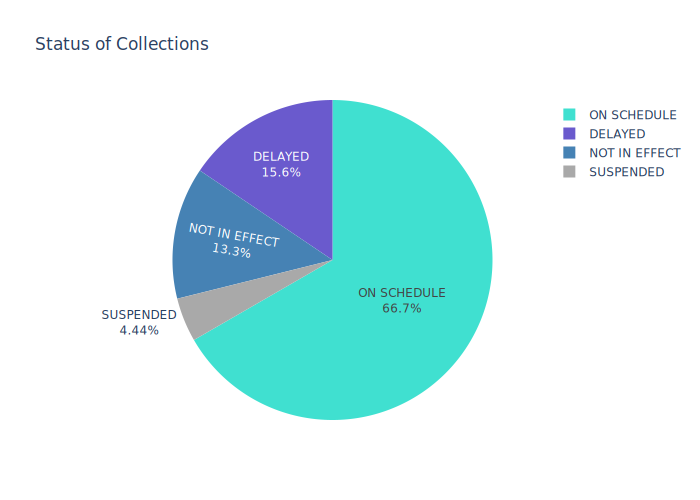

In [129]:
# Creating a Pie Chart to Diplay the Results
# Counting the Occurrences of Each Status
status_counts = trash_filtered_df['status'].value_counts()

# Creating a Pie Chart
plt.figure(figsize=(10,8))
plt.pie(status_counts, labels = status_counts.index, autopct='%1.1f%%', colors=['#40E0D0', '#6A5ACD', '#4682B4', '#A9A9A9'])
plt.title('Status of Collections')
plt.show()